# The modified version is

*   faster
*   Finds a better answer



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future
 
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-11-09 20:22:57--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  26.9MB/s    in 7.7s    

2022-11-09 20:23:05 (24.6 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')

In [6]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [8]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [9]:
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [10]:
df.head()

,userId,movieId,rating,timestamp,new_user_id,new_movie_id
0,1,2,3.5,1112486027,0,1
1,1,29,3.5,1112484676,0,28
2,1,32,3.5,1112484819,0,31
3,1,47,3.5,1112484727,0,46
4,1,50,3.5,1112484580,0,49


In [11]:
# Get userIDs, movie IDs and ratings as seperate arrays
user_ids = df['new_user_id']
movie_ids = df['new_movie_id']
ratings = df['rating'].values - 2.5

In [12]:
# Get the number of users and the number of movies
N = len(set(user_ids))
M = len(set(movie_ids))
# Set embedding dimension
D = 10

In [13]:
# make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim
    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)

    # set the weights since N(0, 1) leads to poor results
    self.u_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.N, self.D) * 0.01)
    )
    self.m_emb.weight.data = nn.Parameter(
        torch.Tensor(np.random.randn(self.M, self.D) * 0.01)
    )

  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)
    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)
    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [16]:
# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [17]:
# A function to encapsulate the training loop
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
  train_users, train_movies, train_ratings = train_data
  test_users, test_movies, test_ratings = test_data
  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  # batches per epoch
  Ntrain = len(train_users)
  batches_per_epoch = int(np.ceil(Ntrain / bs))
  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    # shuffle each batch
    train_users, train_movies, train_ratings = shuffle(train_users, train_movies, train_ratings)
    for j in range(batches_per_epoch):
      # get the batch
      users = train_users[j*bs:(j+1)*bs]
      movies = train_movies[j*bs:(j+1)*bs]
      targets = train_ratings[j*bs:(j+1)*bs]
      # convert to tensor
      users = torch.from_numpy(users.values).long()
      movies = torch.from_numpy(movies.values).long()
      targets = torch.from_numpy(targets)
      # reshape targets
      targets = targets.view(-1, 1).float()
      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)

      # backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for j in range(int(np.ceil(len(test_users) / bs))):
      # get the batch
      users = test_users[j*bs:(j+1)*bs]
      movies = test_movies[j*bs:(j+1)*bs]
      targets = test_ratings[j*bs:(j+1)*bs]
      # convert to tensor
      users = torch.from_numpy(users.values).long()
      movies = torch.from_numpy(movies.values).long()
      targets = torch.from_numpy(targets)
      # reshape targets
      targets = targets.view(-1, 1).float()
      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")


  return train_losses, test_losses

In [18]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [19]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

In [20]:
train_losses, test_losses = batch_gd2(model, criterion, optimizer,
            (train_users, train_movies, train_ratings),
            (test_users, test_movies, test_ratings), epochs=10)

Epoch 1/10, Train Loss: 0.7359, Test Loss: 0.6901, Duration: 0:01:14.522129
Epoch 2/10, Train Loss: 0.6670, Test Loss: 0.6595, Duration: 0:01:01.799579
Epoch 3/10, Train Loss: 0.6339, Test Loss: 0.6466, Duration: 0:00:58.614451
Epoch 4/10, Train Loss: 0.6145, Test Loss: 0.6434, Duration: 0:00:56.986397
Epoch 5/10, Train Loss: 0.5989, Test Loss: 0.6361, Duration: 0:01:08.572537
Epoch 6/10, Train Loss: 0.5861, Test Loss: 0.6344, Duration: 0:01:05.130205
Epoch 7/10, Train Loss: 0.5758, Test Loss: 0.6299, Duration: 0:01:04.555979
Epoch 8/10, Train Loss: 0.5683, Test Loss: 0.6279, Duration: 0:01:04.095972
Epoch 9/10, Train Loss: 0.5625, Test Loss: 0.6288, Duration: 0:00:58.073277
Epoch 10/10, Train Loss: 0.5577, Test Loss: 0.6283, Duration: 0:01:09.123986


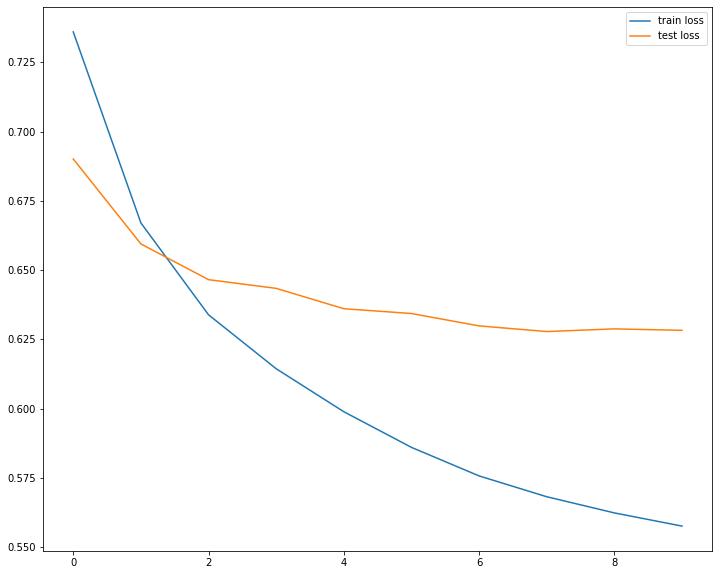

In [21]:
# plot the train loss and test loss per iteration
plt.figure(figsize=(12,10))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [22]:
# suppose I want to find recommendations for user_id = 1
# first find all the movie_ids for movies they haven't yet watched
watched_movie_ids = df[df['new_user_id'] == 1].new_movie_id.values

In [23]:
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [25]:
potential_movie_ids = df[~df['new_movie_id'].isin(watched_movie_ids)].new_movie_id.unique()

In [26]:
# How many
potential_movie_ids.shape

(26683,)

In [27]:
len(set(potential_movie_ids))

26683

In [28]:
# Repeat this user id this many times
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [29]:
user_id_to_recommend

array([1, 1, 1, ..., 1, 1, 1], dtype=int16)

In [30]:
# Convert to torch tensor
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

# Get predictions
with torch.no_grad():
  predictions = model(t_user_ids, t_movie_ids)

In [32]:
# Convert predictions to numpy
predictions_np = predictions.cpu().numpy().flatten()
# Get sort index for predictions (descending order)
sort_idx = np.argsort(-predictions_np)

In [33]:
predictions_np

array([1.5345684 , 0.75209224, 1.8144841 , ..., 1.1833163 , 1.2454679 ,
       1.2415785 ], dtype=float32)

In [34]:
sort_idx

array([ 308,  848,  149, ..., 8583, 8247, 8795])

In [35]:
# Top 10 predictions
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
  print(f"movie: {movie}, score: {score}")

movie: 352, score: 2.73134446144104
movie: 10109, score: 2.6852481365203857
movie: 7041, score: 2.6468393802642822
movie: 5853, score: 2.640658140182495
movie: 7206, score: 2.6365396976470947
movie: 315, score: 2.583536148071289
movie: 1944, score: 2.561509847640991
movie: 4897, score: 2.5424411296844482
movie: 3487, score: 2.541242837905884
movie: 5281, score: 2.5246315002441406
